In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string as st
import re
from random import sample


from os import listdir
from os.path import isfile, join

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from nltk import PorterStemmer, WordNetLemmatizer
import nltk

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package movie_

True

# Read the dataset

In [2]:
with open('data/train_5500.txt','r',encoding = "ISO-8859-1") as file:
    matrix = []
    content = file.readlines()
    for line in content:
        aux = []
        words = line.split()
        aux.append(" ".join(words[1:]))
        aux.append(words[0].split(':')[0])
        matrix.append(aux)
        
df = pd.DataFrame(matrix, columns=['text','category'])
df.head()

,text,category
0,How did serfdom develop in and then leave Russ...,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real na...,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY
4,What is the full form of .com ?,ABBR


In [4]:
np.unique(df['category'],return_counts=True)

(array(['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'], dtype=object),
 array([  86, 1162, 1250, 1223,  835,  896]))

# Reading dataset

In [3]:
mypath = "data/ohsumed/training"
folders = [join(mypath, f) for f in listdir(mypath)]

for fol in folders:
    files = [join(fol, f) for f in listdir(fol) if isfile(join(fol, f))]
    count = 0
    for i,name in enumerate(files):
        count += 1
    print("Class", fol.split('/')[-1],':',count)
    
chosen_classes = ['C06','C08','C10','C12','C20','C21']

Class C13 : 281
Class C10 : 621
Class C15 : 215
Class C06 : 588
Class C16 : 200
Class C12 : 491
Class C22 : 92
Class C05 : 283
Class C14 : 1249
Class C01 : 423
Class C07 : 100
Class C17 : 295
Class C23 : 1799
Class C08 : 473
Class C19 : 191
Class C18 : 388
Class C20 : 525
Class C04 : 1163
Class C03 : 65
Class C11 : 162
Class C02 : 158
Class C21 : 546
Class C09 : 125


In [4]:
dataset_list = []
class_list = []

for clase in chosen_classes:
    fol = join(mypath,clase)
    files = [join(fol, f) for f in listdir(fol) if isfile(join(fol, f))]
    for name in files:
        with open(name,'r',encoding = "ISO-8859-1") as file:
            content = file.read()
            dataset_list.append(content)
            class_list.append(clase)
            
df = pd.DataFrame({"text":dataset_list, "category":class_list})

In [5]:
dataset_list = []

fol = 'data/reuters/training/dlr'
files = [join(fol, f) for f in listdir(fol) if isfile(join(fol, f))]
for name in files:
    with open(name,'r',encoding = "ISO-8859-1") as file:
        content = file.read()
        dataset_list.append(content)
            
df_control = pd.DataFrame({"text":dataset_list, "category":['None']*len(dataset_list)})

In [6]:
print(len(df),len(df_control))

3244 131


# Preprocessing of data

In [7]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

def remove_small_words(text):
    return [x for x in text if len(x) > 4 ]

def remove_stopwords(text):
    # forbidden = ['what', 'which', 'who', 'when', 'why', 'where', 'how', 'many', 'much']
    # stopwords = [x for x in nltk.corpus.stopwords.words('english') if x not in forbidden]
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

def return_sentences(tokens):
    return " ".join([word for word in tokens])

def preprocess_element(text):
    return return_sentences(lemmatize(remove_stopwords(remove_small_words(tokenize(remove_punct(text))))))

print(preprocess_element("What films featured the character Popeye Doyle ?"))

film featured character popeye doyle


In [8]:
df['text'] = df['text'].apply(lambda x: preprocess_element(x))
df_control['text'] = df_control['text'].apply(lambda x: preprocess_element(x))

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['category'],train_size=0.7)
X_test = pd.concat([X_test,df_control['text']])
y_test = pd.concat([y_test,df_control['category']])

classes = np.unique(y_train)

In [9]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train.to_numpy()).todense()
tfidf_test = tfidf.transform(X_test.to_numpy()).todense()


# sim = cosine_similarity(tfidf_vect)


In [10]:
print(np.shape(tfidf_train))

(2270, 16043)


# kNN

In [11]:
knn = KNeighborsClassifier(n_neighbors=15, metric = lambda x,y: 1-np.dot(x,y), weights=lambda x: 1-x)

knn.fit(np.asarray(tfidf_train),np.asarray(y_train))
preds = knn.predict(np.asarray(tfidf_test))
knn_probs = knn.predict_proba(np.asarray(tfidf_test))

In [12]:
acc = knn.score(np.asarray(tfidf_test),np.asarray(y_test))

print("Accuracy: ", acc)

Accuracy:  0.56289592760181


In [11]:
# Las cuatro siguientes son en principio useless
distances, neighbors = knn.kneighbors(np.asarray(tfidf_test))

In [12]:
tag_function = np.vectorize(lambda x: list(y_train)[x])
neigh_tags = tag_function(neighbors)

In [13]:
tag_dist = pd.DataFrame(columns=classes)
for cls in classes:        
    tag_dist[cls] = [np.sum(dists[tags == cls]) for tags, dists in zip(neigh_tags,distances)]
tag_dist.head()

,ABBR,DESC,ENTY,HUM,LOC,NUM
0,0.804247,3.015902,3.787902,1.549652,1.526651,0.751378
1,0.000000,1.173612,0.525297,0.000000,2.937396,5.907371
2,0.000000,1.267678,5.272452,0.701207,0.000000,2.673393
3,0.000000,4.293104,0.799615,0.000000,5.235117,0.740091
4,0.000000,3.335951,3.681918,0.000000,1.460724,2.469960


In [14]:
distribution = tag_dist.apply(lambda lst: lst/np.sum(lst), axis=1)
distribution.head()

,ABBR,DESC,ENTY,HUM,LOC,NUM
0,0.070328,0.263726,0.331234,0.135510,0.133498,0.065704
1,0.000000,0.111310,0.049821,0.000000,0.278593,0.560276
2,0.000000,0.127858,0.531780,0.070724,0.000000,0.269639
3,0.000000,0.387887,0.072246,0.000000,0.472999,0.066868
4,0.000000,0.304693,0.336293,0.000000,0.133417,0.225597


In [13]:
# for i,cls in enumerate(classes):
#     print("Number of times that", cls, "was predicted:", np.sum([np.argmax(row) == i for row in distribution.to_numpy()]))
# Making a ROC curve to decide a good threshold. In this case, all the classes are positives, instead of the None one
y_real = []
for pred in y_test:
    if pred == "None":
        y_real.append(0)
    else:
        y_real.append(1)
        


In [14]:
fpr, tpr, thresholds = roc_curve(y_real, [np.max(row) for row in probs])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

NameError: name 'probs' is not defined

# Neural Networks

In [ ]:
sizes = [8,16,32,64]

max_acc = 0
for i in sizes:
    for j in sizes:
        for k in sizes:
            nn = MLPClassifier([i,j,k], early_stopping=True, n_iter_no_change=20, learning_rate='adaptive')
            nn.fit(np.asarray(tfidf_train),np.asarray(y_train))
            acc = nn.score(np.asarray(tfidf_test),np.asarray(y_test))
            if max_acc < acc:
                max_acc = acc
                best_conf = nn
    
print("Number of layers: ", best_conf.get_params()["hidden_layer_sizes"])
print("Accuracy: ", max_acc)

In [15]:
nn = MLPClassifier([256,128,64], early_stopping=True, n_iter_no_change=20, learning_rate='adaptive')
nn.fit(np.asarray(tfidf_train),np.asarray(y_train))
acc = nn.score(np.asarray(tfidf_test),np.asarray(y_test))

print("Accuracy: ", acc)

Accuracy:  0.5547511312217195


In [16]:
nn_probs = nn.predict_proba(np.asarray(tfidf_test))

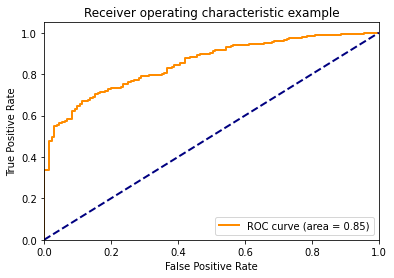

In [16]:
fpr, tpr, thresholds = roc_curve(y_real, [np.max(row) for row in probs])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# ROC and Precision-Recall Curves

In [19]:
# Converts the test predictions into binary ones
def convert_classes(y_test):
    y_real = []
    for pred in y_test:
        if pred == "None":
            y_real.append(0)
        else:
            y_real.append(1)
    return y_real

# Apart from plotting the correponding ROC curve, it returns the best threshold
def plot_one_roc(y_real,probs,name):
    fpr, tpr, thresholds = roc_curve(y_real, [np.max(row) for row in probs])
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=name + " ROC curve (area = %0.2f)" % roc_auc,
    )
    # Calculation of best threshold
    argmax = np.argmax(tpr*(1-fpr))
    print("Best threshold in "+name+": "+str(thresholds[argmax]))
    print("Best TPR in "+name+": "+str(tpr[argmax]))
    print("Best FPR in "+name+": "+str(fpr[argmax]))
    print()
    return thresholds[argmax]

# Plot both ROC curves: knn and neural network
def plot_roc_curves(y_test, knn_probs, nn_probs):
    best_thres = {}
    plt.figure()
    
    lw = 2
    y_real = convert_classes(y_test)
    
    best_thres['knn'] = plot_one_roc(y_real,knn_probs,"kNN")
    best_thres['nn'] = plot_one_roc(y_real,nn_probs,"Neural Net")
    
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    
    return best_thres

Best threshold in kNN: 0.4736818592098461
Best TPR in kNN: 0.6529774127310062
Best FPR in kNN: 0.1984732824427481

Best threshold in Neural Net: 0.5829413052078531
Best TPR in Neural Net: 0.7248459958932238
Best FPR in Neural Net: 0.15267175572519084



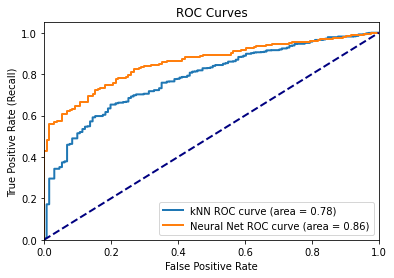

In [20]:
best_thres = plot_roc_curves(y_test, knn_probs, nn_probs)

In [29]:
def plot_one_recprec(y_real,probs,name):
    precision, recall, thresholds = precision_recall_curve(y_real, [np.max(row) for row in probs])
    # Precision empieza en 1 en vez de en 0
    lw = 2
    plt.plot(
        recall,
        precision,
        # color="darkorange",
        lw=lw,
        label=name,
    )
    print(thresholds)

# Plot both Precision-Recall curves: knn and neural network
def plot_recprec_curves(y_test, knn_probs, nn_probs):
    best_thres = {}
    plt.figure()
    
    lw=2
    y_real = convert_classes(y_test)
    
    best_thres['knn'] = plot_one_recprec(y_real,knn_probs,"kNN")
    best_thres['nn'] = plot_one_recprec(y_real,nn_probs,"Neural Net")

    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="lower left")
    plt.show()


[0.21241603 0.22240642 0.22409221 ... 0.96001601 0.96142591 1.        ]
[0.20294064 0.22283791 0.23155427 ... 0.99547778 0.99593923 0.99599722]


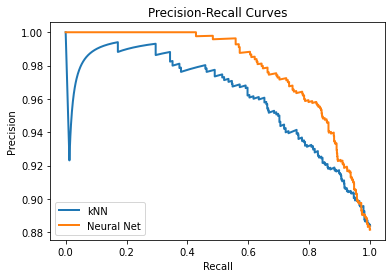

In [30]:
plot_recprec_curves(y_test, knn_probs, nn_probs)